In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from keras.datasets import fashion_mnist

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [4]:
print(X_test.shape, X_train.shape)

(10000, 28, 28) (60000, 28, 28)


[10332 18448 37192 26126 17663 20682 10312 50954]


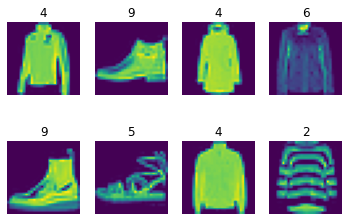

In [5]:
#lets visualize few images 
sample = np.random.randint(0,high= 59999, size=8)
print(sample)
sample_img = X_train[sample, :]
sample_label = Y_train[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img)
plt.show()

In [6]:
#Defining constants
epochs = 200
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [7]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [8]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
__________

In [9]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

/home/porwalkakshak/saved_model/fmnist_resnet_model.h5


In [10]:
if not data_augmentation:
    print('Using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Using data augmentation.

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 26s 439us/step - loss: 1.2043 - accuracy: 0.8497 - val_loss: 0.9174 - val_accuracy: 0.8842

Epoch 00001: val_loss improved from inf to 0.91736, saving model to /home/porwalkakshak/saved_model/fmnist_resnet_model.h5
Epoch 2/200
60000/60000 [==============================] - 19s 312us/step - loss: 0.7645 - accuracy: 0.8963 - val_loss: 0.7052 - val_accuracy: 0.8903

Epoch 00002: val_loss improved from 0.91736 to 0.70522, saving model to /home/porwalkakshak/saved_model/fmnist_resnet_model.h5
Epoch 3/200
60000/60000 [==============================] - 18s 305us/step - loss: 0.5871 - accuracy: 0.9094 - val_loss: 0.6116 - val_accuracy: 0.8934

Epoch 00003: val_loss improved from 0.70522 to 0.61165, saving model to /home/porwalkakshak/saved_model/fmnist_resnet_model.h5
Epoch 4/200
60000/60000 [==============================] - 19s 309us/step - loss: 0.4946 - acc

60000/60000 [==============================] - 18s 303us/step - loss: 0.0784 - accuracy: 1.0000 - val_loss: 0.8526 - val_accuracy: 0.9216

Epoch 00037: val_loss did not improve from 0.42935
Epoch 38/200
60000/60000 [==============================] - 18s 303us/step - loss: 0.0775 - accuracy: 1.0000 - val_loss: 0.8643 - val_accuracy: 0.9213

Epoch 00038: val_loss did not improve from 0.42935
Epoch 39/200
60000/60000 [==============================] - 18s 303us/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 0.8732 - val_accuracy: 0.9220

Epoch 00039: val_loss did not improve from 0.42935
Epoch 40/200
60000/60000 [==============================] - 18s 301us/step - loss: 0.0765 - accuracy: 1.0000 - val_loss: 0.8807 - val_accuracy: 0.9221

Epoch 00040: val_loss did not improve from 0.42935
Epoch 41/200
60000/60000 [==============================] - 18s 301us/step - loss: 0.0760 - accuracy: 1.0000 - val_loss: 0.8861 - val_accuracy: 0.9217

Epoch 00041: val_loss did not improve from 0.4293

60000/60000 [==============================] - 18s 304us/step - loss: 0.0665 - accuracy: 1.0000 - val_loss: 1.0072 - val_accuracy: 0.9217

Epoch 00077: val_loss did not improve from 0.42935
Epoch 78/200
60000/60000 [==============================] - 19s 309us/step - loss: 0.0663 - accuracy: 1.0000 - val_loss: 1.0091 - val_accuracy: 0.9215

Epoch 00078: val_loss did not improve from 0.42935
Epoch 79/200
60000/60000 [==============================] - 18s 303us/step - loss: 0.0661 - accuracy: 1.0000 - val_loss: 1.0112 - val_accuracy: 0.9222

Epoch 00079: val_loss did not improve from 0.42935
Epoch 80/200
60000/60000 [==============================] - 18s 306us/step - loss: 0.0660 - accuracy: 1.0000 - val_loss: 1.0171 - val_accuracy: 0.9216

Epoch 00080: val_loss did not improve from 0.42935
Epoch 81/200
60000/60000 [==============================] - 18s 306us/step - loss: 0.0658 - accuracy: 1.0000 - val_loss: 1.0082 - val_accuracy: 0.9215

Epoch 00081: val_loss did not improve from 0.4293

60000/60000 [==============================] - 18s 302us/step - loss: 0.0602 - accuracy: 1.0000 - val_loss: 1.0369 - val_accuracy: 0.9207

Epoch 00117: val_loss did not improve from 0.42935
Epoch 118/200
60000/60000 [==============================] - 18s 303us/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 1.0364 - val_accuracy: 0.9197

Epoch 00118: val_loss did not improve from 0.42935
Epoch 119/200
60000/60000 [==============================] - 18s 299us/step - loss: 0.0599 - accuracy: 1.0000 - val_loss: 1.0347 - val_accuracy: 0.9189

Epoch 00119: val_loss did not improve from 0.42935
Epoch 120/200
60000/60000 [==============================] - 18s 302us/step - loss: 0.0598 - accuracy: 1.0000 - val_loss: 1.0315 - val_accuracy: 0.9192

Epoch 00120: val_loss did not improve from 0.42935
Epoch 121/200
60000/60000 [==============================] - 18s 305us/step - loss: 0.0597 - accuracy: 1.0000 - val_loss: 1.0289 - val_accuracy: 0.9203

Epoch 00121: val_loss did not improve from 0.

60000/60000 [==============================] - 18s 300us/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 1.0366 - val_accuracy: 0.9208

Epoch 00157: val_loss did not improve from 0.42935
Epoch 158/200
60000/60000 [==============================] - 18s 302us/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 1.0341 - val_accuracy: 0.9205

Epoch 00158: val_loss did not improve from 0.42935
Epoch 159/200
60000/60000 [==============================] - 18s 299us/step - loss: 0.0542 - accuracy: 1.0000 - val_loss: 1.0395 - val_accuracy: 0.9204

Epoch 00159: val_loss did not improve from 0.42935
Epoch 160/200
60000/60000 [==============================] - 18s 300us/step - loss: 0.0541 - accuracy: 1.0000 - val_loss: 1.0357 - val_accuracy: 0.9200

Epoch 00160: val_loss did not improve from 0.42935
Epoch 161/200
60000/60000 [==============================] - 18s 299us/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 1.0336 - val_accuracy: 0.9206

Epoch 00161: val_loss did not improve from 0.

60000/60000 [==============================] - 18s 300us/step - loss: 0.0513 - accuracy: 1.0000 - val_loss: 1.0205 - val_accuracy: 0.9202

Epoch 00197: val_loss did not improve from 0.42935
Epoch 198/200
60000/60000 [==============================] - 18s 306us/step - loss: 0.0513 - accuracy: 1.0000 - val_loss: 1.0259 - val_accuracy: 0.9203

Epoch 00198: val_loss did not improve from 0.42935
Epoch 199/200
60000/60000 [==============================] - 18s 299us/step - loss: 0.0512 - accuracy: 1.0000 - val_loss: 1.0196 - val_accuracy: 0.9206

Epoch 00199: val_loss did not improve from 0.42935
Epoch 200/200
60000/60000 [==============================] - 18s 299us/step - loss: 0.0511 - accuracy: 1.0000 - val_loss: 1.0193 - val_accuracy: 0.9204

Epoch 00200: val_loss did not improve from 0.42935


In [11]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



10000/10000 [==============================] - 2s 218us/step
Test loss: 1.019313760948181
Test accuracy: 0.9204000234603882


In [13]:
import tensorflow as tf

model_filepath = './saved_model/fmnist_resnet_model.h5'

model = tf.keras.models.load_model(
    model_filepath
)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________